# Определение возраста покупателей

## Исследовательский анализ данных

**Проект: "Исследовательский анализ датасета для определения возраста по фотографиям"**

**Цель исследования:**

Изучить структуру и особенности предоставленного датасета (/datasets/faces/)

**Задачи исследования:**

1. Анализ размера и структуры выборки

2. Визуализация распределения возраста

3. Просмотр примеров изображений

4. Выводы для обучения модели


Импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Размер выборки

In [2]:
df = pd.read_csv('/datasets/faces/labels.csv')

df.shape

(7591, 2)

In [3]:
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
df['file_name'].duplicated().sum()

0

In [6]:
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


*Вывод*: 
1. Данные загружены и соответствуют ТЗ. 
2. Дубликаты и пропуски отсуствуют.
3. Размер - 7591 изображений.

### Визуализация

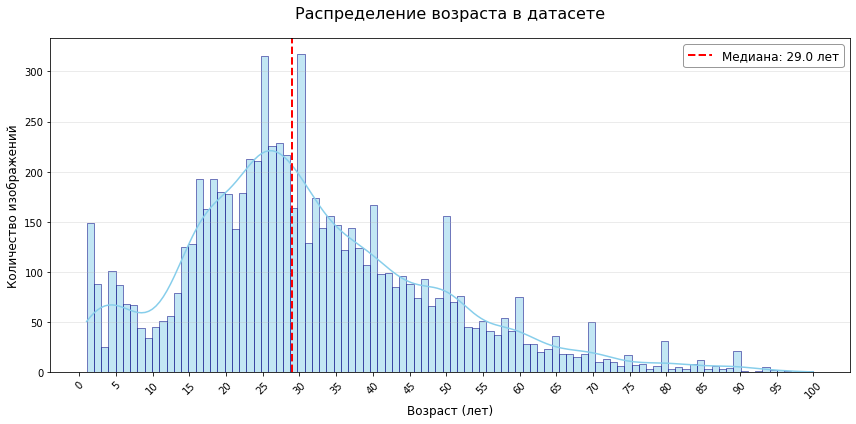

In [7]:
plt.figure(figsize=(12, 6))

median_age = df['real_age'].median()

ax = sns.histplot(data=df, x='real_age', bins=100, 
                 kde=True, color='skyblue', 
                 edgecolor='navy', linewidth=0.5)

plt.axvline(median_age, color='red', linestyle='--', linewidth=2, 
           label=f'Медиана: {median_age:.1f} лет')

plt.title('Распределение возраста в датасете', fontsize=16, pad=20)
plt.xlabel('Возраст (лет)', fontsize=12)
plt.ylabel('Количество изображений', fontsize=12)
plt.grid(axis='y', alpha=0.3)

plt.legend(fontsize=12, frameon=True, 
          facecolor='white', edgecolor='gray')

ax.set_xticks(range(0, df['real_age'].max()+1, 5))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

*Вывод:*

1. Медиана - 29 лет.
2. Самый частый возраст ~ 25 лет.
3. Самые нечастные 80-100 лет.
4. Максимальный возраст - 100 лет.
5. Минимальный возраст - 1 год.

### Примеры изображений

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)


image_flow = datagen.flow_from_dataframe(
    dataframe=df,
    directory='/datasets/faces/final_files',  
    x_col='file_name',                       
    y_col='real_age',                        
    target_size=(150, 150),                  
    batch_size=15,                           
    class_mode='raw',                        
    shuffle=True                            
)

images, ages = next(image_flow)

plt.figure(figsize=(15, 10))
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(images[i])
    plt.title(f'Возраст: {int(ages[i])}', fontsize=10)
    plt.axis('off')
plt.suptitle('Примеры изображений из датасета с указанием возраста', fontsize=16)
plt.tight_layout()
plt.show()

*Вывод:*

1. Некоторые фотографии в плохом качестве 
2. Некоторые фотографии содержат фильтры
3. Некоторые фотографии содедржат черные рамки

### Общий вывод

Вывод:

1. Данные загружены и соответствуют ТЗ. 
2. Дубликаты и пропуски отсуствуют.
3. Размер - 7591 изображений.
1. Медиана - 29 лет.
2. Самый частый возраст ~ 25 лет.
3. Самые нечастные 80-100 лет.
4. Максимальный возраст - 100 лет.
5. Минимальный возраст - 1 год.
1. Некоторые фотографии в плохом качестве.
2. Некоторые фотографии содержат фильтры.
3. Некоторые фотографии содедржат черные рамки.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
import numpy as np
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1/255., validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        subset='training',
        directory=path + 'final_files/',
        target_size=(224, 224),
        batch_size=16,
        seed=12345)

    return train_datagen_flow

def load_test(path):
    train_datagen = ImageDataGenerator(rescale=1/255., validation_split=0.25)
    test_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        subset='validation',
        directory=path + 'final_files/',
        target_size=(224, 224),
        batch_size=16,
        seed=12345)

    return test_datagen_flow

def create_model(input_shape=(224, 224, 3)):
    model = Sequential()
    backbone = ResNet50(
        input_shape=input_shape, 
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
        include_top=False)

    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.0001)
    model.compile(
        optimizer=optimizer, 
        loss='mse',
        metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

```

Train for 356 steps, validate for 119 steps
Epoch 1/5
356/356 - 97s - loss: 197.5938 - mae: 10.2103 - val_loss: 440.4561 - val_mae: 15.8227
Epoch 2/5
356/356 - 47s - loss: 66.0109 - mae: 6.1980 - val_loss: 121.9848 - val_mae: 8.3455
Epoch 3/5
356/356 - 47s - loss: 37.8944 - mae: 4.7349 - val_loss: 80.9530 - val_mae: 6.7527
Epoch 4/5
356/356 - 47s - loss: 26.7836 - mae: 3.9584 - val_loss: 73.8397 - val_mae: 6.6640
Epoch 5/5
356/356 - 47s - loss: 19.6089 - mae: 3.3670 - val_loss: 73.0907 - val_mae: 6.4339
119/119 - 12s - loss: 73.0907 - mae: 6.4339


```

## Анализ обученной модели

**Вывод:**

1. Основа модели — ResNet50.
2. Добавлен GlobalAveragePooling2D для уменьшения размерности.
3. Выходной слой — Dense(1, activation='relu').
4. Оптимизатор: Adam с learning rate = 0.0001.
5. Функция потерь: MSE.
6. Функция потерь: MSE.
7. Обучение на 5 эпохах.
8. Результат: **MAE = 6.43**.